# PALM quick dev

In [5]:
%matplotlib notebook
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from peaks.peakfinder import PeakFinder
from peaks.gauss2d import Gauss2D
import skimage.external.tifffile as tif
from matplotlib.colors import LogNorm, PowerNorm

## Setup

First we need to find the files, check the data and check the fitting algorithm

In [6]:
# find files, all on disk thankfully
files_to_process = sorted(glob.glob("Raw Data for Slab0/*.tif"))
files_to_process[::100]

['Raw Data for Slab0\\3DPALM_532nma_Iter_000_000_ch0_CAM1_stack0000_532nm_0000000msec_0003931739msecAbs_000x_000y_000z_0000t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_100_000_ch0_CAM1_stack0000_532nm_0000000msec_0030206706msecAbs_000x_000y_000z_0100t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_200_000_ch0_CAM1_stack0000_532nm_0000000msec_0056495843msecAbs_000x_000y_000z_0200t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_300_000_ch0_CAM1_stack0000_532nm_0000000msec_0082797772msecAbs_000x_000y_000z_0300t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_400_000_ch0_CAM1_stack0000_532nm_0000000msec_0109219064msecAbs_000x_000y_000z_0400t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_500_000_ch0_CAM1_stack0000_532nm_0000000msec_0135630201msecAbs_000x_000y_000z_0500t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_600_000_ch0_CAM1_stack0000_532nm_0000000msec_0162060612msecAbs_000x_000y_000z_0600t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_700_000_ch0_CAM1_stack0000_532nm_0000000ms

In [7]:
# grab a test stack
test_stack = tif.imread(files_to_process[350])

<IPython.core.display.Javascript object>


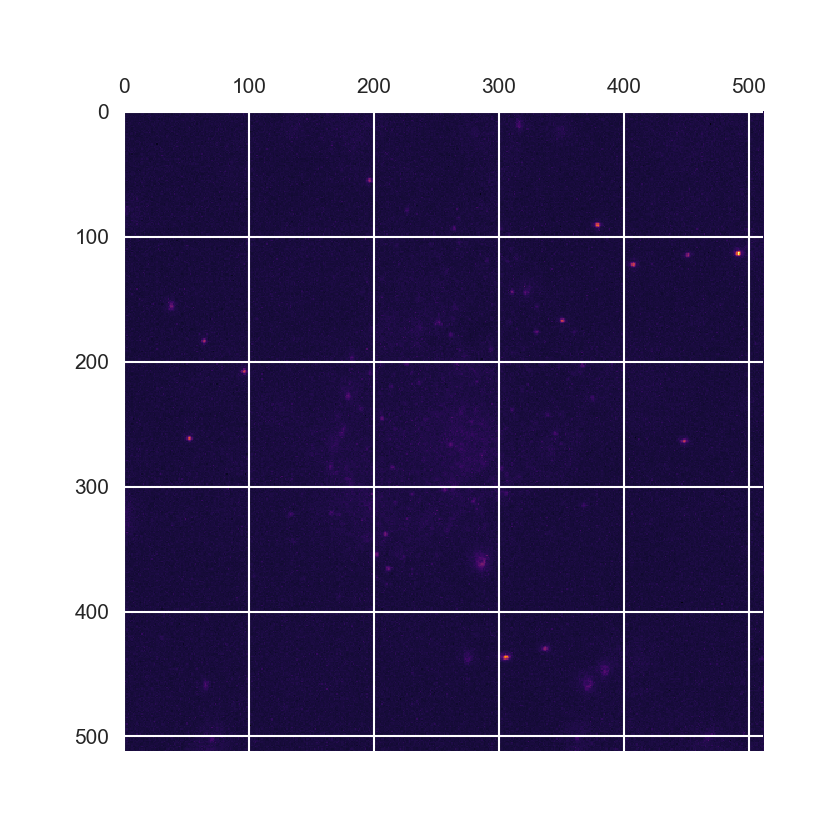

In [8]:
# plot a frame
plt.matshow(test_stack[0], cmap="inferno")

In [15]:
%%time
# try a fit
test_pf = PeakFinder(test_stack[0], 1.4, 15)
# test_pf.thresh = 10
# test_pf.find_blobs(min_sigma=1.0, max_sigma=2.0)
test_pf.find_blobs()
test_pf.remove_edge_blobs(10)
test_pf.fit_blobs(9, quiet=True, fittype="mle")

Wall time: 276 ms


52


<IPython.core.display.Javascript object>


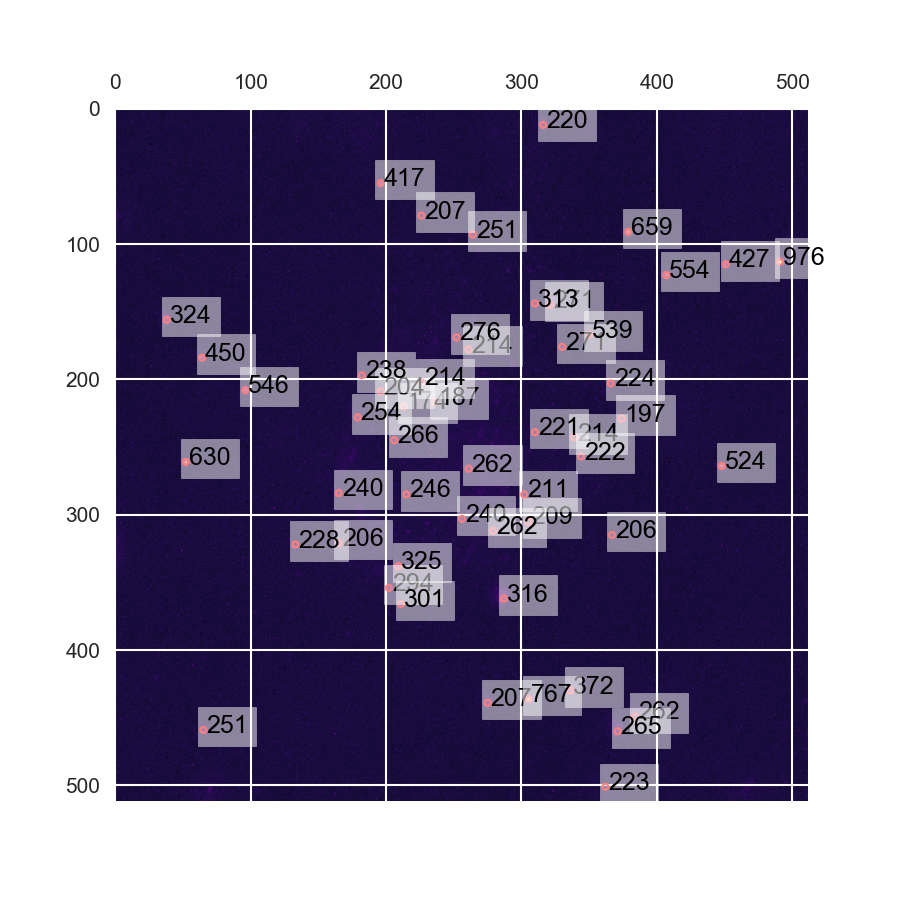

(<matplotlib.figure.Figure at 0x182b77fb748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182b77f9b00>)

In [16]:
# check the fit
print(len(test_pf.blobs))
test_pf.plot_blobs(cmap="inferno", norm=PowerNorm(1))

In [17]:
# get multiprocessing support
import dask
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.multiprocessing

# Lazy functions for raw data handling
lazy_imread = dask.delayed(tif.imread, pure=True)

def make_lazy_data(paths):
    """Make a lazy data array from a set of paths to data

    Assumes all data is of same shape and type."""
    lazy_data = [lazy_imread(path) for path in paths]
    # read first image for shape
    sample = tif.imread(paths[0])
    data = [da.from_delayed(ld, shape=sample.shape, dtype=sample.dtype) for ld in lazy_data]
    data_array = da.concatenate(data)
    return data_array

In [18]:
all_frames = make_lazy_data(files_to_process)

In [19]:
all_frames

dask.array<concatenate, shape=(190750, 512, 512), dtype=uint16, chunksize=(250, 512, 512)>

In [27]:
def junk(j1, j2, *, j3=4, j4=4):
    pass

In [29]:
junk(1, 2, j4=1)

In [30]:
def fit_frame(data, frame, fit_width=9, bg=15, fittype="ls"):
    """Fit a single frame of data
    
    Parameters
    ----------
    data : ndarray (2D)
        the data to find and fit peaks
    frame"""
    pf = PeakFinder(data, 1.4, bg)
#     test_pf.thresh = 10
    pf.find_blobs()
    if len(pf.blobs):
        pf.blobs = pf.blobs[:100]
    pf.remove_edge_blobs(10)
    pf_fits = pf.fit_blobs(fit_width, fittype=fittype, quiet=True)
    pf_fits["frame"]=frame
    return pf_fits

def fit_blocks(block, offset, fittype="ls"):
    # turn delayed into data
    # sometimes actual array is passed, not sure why, something do do with 
    try:
        data = block.compute()
    except AttributeError:
        data = block
    j = len(data) * offset
    df = pd.concat([fit_frame(d, i + j, fittype=fittype) for i, d in enumerate(data)])
    return df

fit_blocks_delayed = dask.delayed(pure=True)(fit_blocks)

In [31]:
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, "mle") for i, d in enumerate(all_frames.to_delayed().squeeze())])

In [32]:
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Raw_MLE_wbg.h5", "raw_fits")

[########################################] | 100% Completed | 56min 31.4s
